In [1]:
from datetime import datetime
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 7
plt.rcParams['font.size'] = 12
mpl.rcParams['savefig.format'] = 'pdf'
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")

In [2]:
game_data = pd.read_csv('/kaggle/input/video-game-sales-2024/vgchartz-2024.csv')

In [3]:
game_data.shape

(64016, 14)

In [4]:
game_data.sample(10)

,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
13480,/games/boxart/full_1292517JapanFrontccc.jpg,Ailu de Puzzle,PSP,Puzzle,Capcom,Natsume Atari,NaN,0.04,NaN,0.04,NaN,NaN,2012-07-19,2019-04-26
1345,/games/boxart/full_7855038AmericaFrontccc.jpg,Grand Theft Auto: Chinatown Wars,PSP,Adventure,Rockstar Games,Rockstar Leeds,9.2,1.08,0.28,0.03,0.50,0.27,2009-10-20,NaN
24657,/games/boxart/full_5917508AmericaFrontccc.jpg,Danganronpa,Series,Adventure,NIS America,Spike Chunsoft,NaN,NaN,NaN,NaN,NaN,NaN,2014-02-11,2021-10-20
21711,/games/boxart/full_7369897AmericaFrontccc.jpg,OniKira: Demon Killer,PC,Action,Unknown,Digital Furnace Games,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-01,2018-09-21
14209,/games/boxart/full_9898523AmericaFrontccc.jpg,Silent Scope,GBA,Shooter,Konami,Konami,NaN,0.03,0.02,NaN,0.01,0.00,2002-09-04,NaN
18651,/games/boxart/default.jpg,IL-2 Sturmovik: Battle of Stalingrad,PC,Action,1C Maddox Games,Unknown,NaN,0.00,NaN,NaN,0.00,0.00,2014-11-25,NaN
47939,/games/boxart/full_3752594AmericaFrontccc.jpg,Miitopia,NS,Role-Playing,Nintendo,Nintendo,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-21,2021-02-18
2210,/games/boxart/5958012ccc.jpg,Berzerk,2600,Shooter,Atari,Stern Electronics,NaN,0.73,0.68,NaN,0.04,0.01,1982-01-01,NaN
30793,/games/boxart/full_naruto-shippuden-ultimate-n...,Naruto Shippuden: Ultimate Ninja Storm 2,PS3,Fighting,Namco Bandai,CyberConnect2,7.3,NaN,NaN,NaN,NaN,NaN,2010-10-19,NaN
57334,/games/boxart/full_9705805JapanFrontccc.jpg,Train Simulator + Densha de Go! Tokyo Kyuukouhen,PS2,Simulation,Taito,Taito Corporation,NaN,NaN,NaN,NaN,NaN,NaN,2003-12-18,NaN


In [5]:
def decorate(styler, name='', v_min=0, v_max=0):
    styler.set_caption(name)
    styler.background_gradient(axis=None, vmin=v_min, vmax=v_max, cmap=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True))
    return styler

In [6]:
display(decorate(pd.DataFrame(game_data.isna().sum(), columns=['Number of NaNs'])
                 .rename_axis('Column', axis='columns').style, 'Empty cells', 0, 60000))

Column,Number of NaNs
img,0
title,0
console,0
genre,0
publisher,0
developer,17
critic_score,57338
total_sales,45094
na_sales,51379
jp_sales,57290


We see, that there is a lot of NaNs in the columns, that contain the most valuable information. Among them total sales is the most critical.
But maybe there are some rows where we have sales number for different countries, but do not have total sales number. Let's estimate total_sales as sum of na_sales, jp_sales, pal_sales and other_sales. If one of this values is NaN, let's set them as zero.

In [7]:
game_data.loc[:, ['na_sales', 'jp_sales', 'pal_sales', 'other_sales']] =\
    game_data.loc[:, ['na_sales', 'jp_sales', 'pal_sales', 'other_sales']].fillna(0)

In [8]:
non_zero_total = (game_data[game_data['total_sales'].isna()][['na_sales', 'jp_sales', 'pal_sales', 'other_sales']].sum(axis=1) != 0).sum()

In [9]:
print('Total sales, that will change from NaN to nonzero:', non_zero_total)

Total sales, that will change from NaN to nonzero: 0


As we see, that is not the case. Then let's erase all rows with 0 total sales.

In [10]:
game_data = game_data[game_data['total_sales'].notna()]

In [11]:
display(decorate(pd.DataFrame(game_data.isna().sum(), columns=['Number of NaNs'])
                 .rename_axis('Column', axis='columns').style, 'Empty cells', 0, 15000))

Column,Number of NaNs
img,0
title,0
console,0
genre,0
publisher,0
developer,4
critic_score,14796
total_sales,0
na_sales,0
jp_sales,0


For the rows with NaNs in last_update column we can set last update equal to the release date. And if we have last update, but do not have release date, lets consider release date is equal to the last update. Let's delete games with both dates unknown.

In [12]:
game_data.loc[game_data['last_update'].isna(), 'last_update'] = game_data.loc[game_data['last_update'].isna(), 'release_date']
game_data.loc[game_data['release_date'].isna(), 'release_date'] = game_data.loc[game_data['release_date'].isna(), 'last_update']

In [13]:
game_data = game_data[game_data['last_update'].notna()]

In [14]:
display(decorate(pd.DataFrame(game_data.isna().sum(), columns=['Number of NaNs'])
                 .rename_axis('Column', axis='columns').style, 'Empty cells', 0, 15000))

Column,Number of NaNs
img,0
title,0
console,0
genre,0
publisher,0
developer,3
critic_score,14712
total_sales,0
na_sales,0
jp_sales,0


In [15]:
game_data[game_data['developer'].isna()]

,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
8486,/games/boxart/21030ccc.jpg,Gourmet Chef: Cook Your Way to Fame,DS,Misc,Ubisoft,NaN,NaN,0.14,0.13,0.0,0.0,0.01,2008-06-24,2008-06-24
10832,/games/boxart/2426879ccc.jpg,Wordmaster,DS,Strategy,"Destination Software, Inc",NaN,NaN,0.09,0.09,0.0,0.0,0.01,2008-08-12,2008-08-12
18185,/games/boxart/8436780ccc.jpg,SAS: Secure Tomorrow,PC,Shooter,City Interactive,NaN,NaN,0.00,0.00,0.0,0.0,0.00,2008-10-16,2008-10-16


For NaNs in developer column let's set the same company as in publisher column. 

In [16]:
game_data.loc[game_data['developer'].isna(), 'developer'] = game_data.loc[game_data['developer'].isna(), 'publisher']

As we see, there is a lot of zeros in critic_score. In this case we want to set all NaNs in that column to zeros, but also add binary column has_critic_score, which will contain info about which score is real and which one was set to zero by us. 

In [17]:
game_data['has_critic_score'] = (1 - game_data['critic_score'].isna().astype(int)).astype(bool)
game_data.loc[game_data['critic_score'].isna(), 'critic_score'] = 0

In [18]:
display(decorate(pd.DataFrame(game_data.isna().sum(), columns=['Number of NaNs'])
                 .rename_axis('Column', axis='columns').style, 'Empty cells', 0, 15000))

Column,Number of NaNs
img,0
title,0
console,0
genre,0
publisher,0
developer,0
critic_score,0
total_sales,0
na_sales,0
jp_sales,0


In [19]:
cols = ['img', 'title', 'console', 'genre', 'publisher', 'developer',
        'has_critic_score', 'critic_score', 'total_sales', 'na_sales',
        'jp_sales', 'pal_sales', 'other_sales', 'release_date', 'last_update']

game_data = game_data[cols]

Now let's finally describe dtypes and talk about columns and values.

In [20]:
numeric_columns = game_data.select_dtypes(include=np.number).columns.tolist()
str_columns = list(set(game_data.columns.tolist()) - set(numeric_columns))
print('Numeric columns:', numeric_columns, '\nObject columns:', str_columns)

Numeric columns: ['critic_score', 'total_sales', 'na_sales', 'jp_sales', 'pal_sales', 'other_sales'] 
Object columns: ['title', 'console', 'developer', 'release_date', 'publisher', 'img', 'last_update', 'genre', 'has_critic_score']


Updating release_date and last_update dtype to datetime from Object.

In [21]:
game_data['release_date'] = pd.to_datetime(game_data['release_date'])
game_data['last_update'] = pd.to_datetime(game_data['last_update'])

In [22]:
game_data.dtypes

img                         object
title                       object
console                     object
genre                       object
publisher                   object
developer                   object
has_critic_score              bool
critic_score               float64
total_sales                float64
na_sales                   float64
jp_sales                   float64
pal_sales                  float64
other_sales                float64
release_date        datetime64[ns]
last_update         datetime64[ns]
dtype: object

|      Column     |      Dtype      | Description|
|-----------------|-----------------|------------|
|img              |           object| Logo of the game |
|title            |           object| Title of the game |
|console          |           object| Device for the game |
|genre            |           object| Genre of the game |
|publisher        |           object| Publisher of the game |
|developer        |           object| Developer of the game |
|has_critic_score |             bool| Does the game have known critic_score or not |
|critic_score     |          float64| Critic score or rating of the game |
|total_sales      |          float64| Number of total sales of the game |
|na_sales         |          float64| Number of sales in the North America |
|jp_sales         |          float64| Number of sales in the Japan |
|pal_sales        |          float64| Number of sales in PAL countries
|other_sales      |          float64| Number of sales in other countries or other types of sales |
|release_date     |   datetime64[ns]| Release date of the game |
|last_update      |   datetime64[ns]| Date of the last update of the game |

In [23]:
game_data.sample(3)

,img,title,console,genre,publisher,developer,has_critic_score,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
6314,/games/boxart/full_8765816JapanFrontccc.jpg,Jikkyou Powerful Pro Yakyuu 2001,PS,Sports,Konami,Diamond Head,False,0.0,0.24,0.00,0.23,0.00,0.02,2001-06-07,2001-06-07
4743,/games/boxart/9712535ccc.jpg,Thunderstrike: Operation Phoenix,PS2,Simulation,Eidos Interactive,Core Design Ltd.,False,0.0,0.34,0.17,0.00,0.13,0.04,2001-10-15,2001-10-15
14947,/games/boxart/full_8879401AmericaFrontccc.jpg,Sea Park Tycoon,DS,Simulation,Destineer,Most Wanted Entertainment,False,0.0,0.03,0.02,0.00,0.01,0.00,2010-04-13,2010-04-13


In [24]:
game_data[numeric_columns].describe()

,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales
count,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000
mean,1.554595,0.350391,0.177582,0.036382,0.101654,0.034537
std,3.012929,0.808982,0.423947,0.112080,0.331328,0.114763
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.030000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.120000,0.050000,0.000000,0.010000,0.010000
75%,0.000000,0.350000,0.170000,0.020000,0.070000,0.020000
max,10.000000,20.320000,9.760000,2.130000,9.850000,3.120000


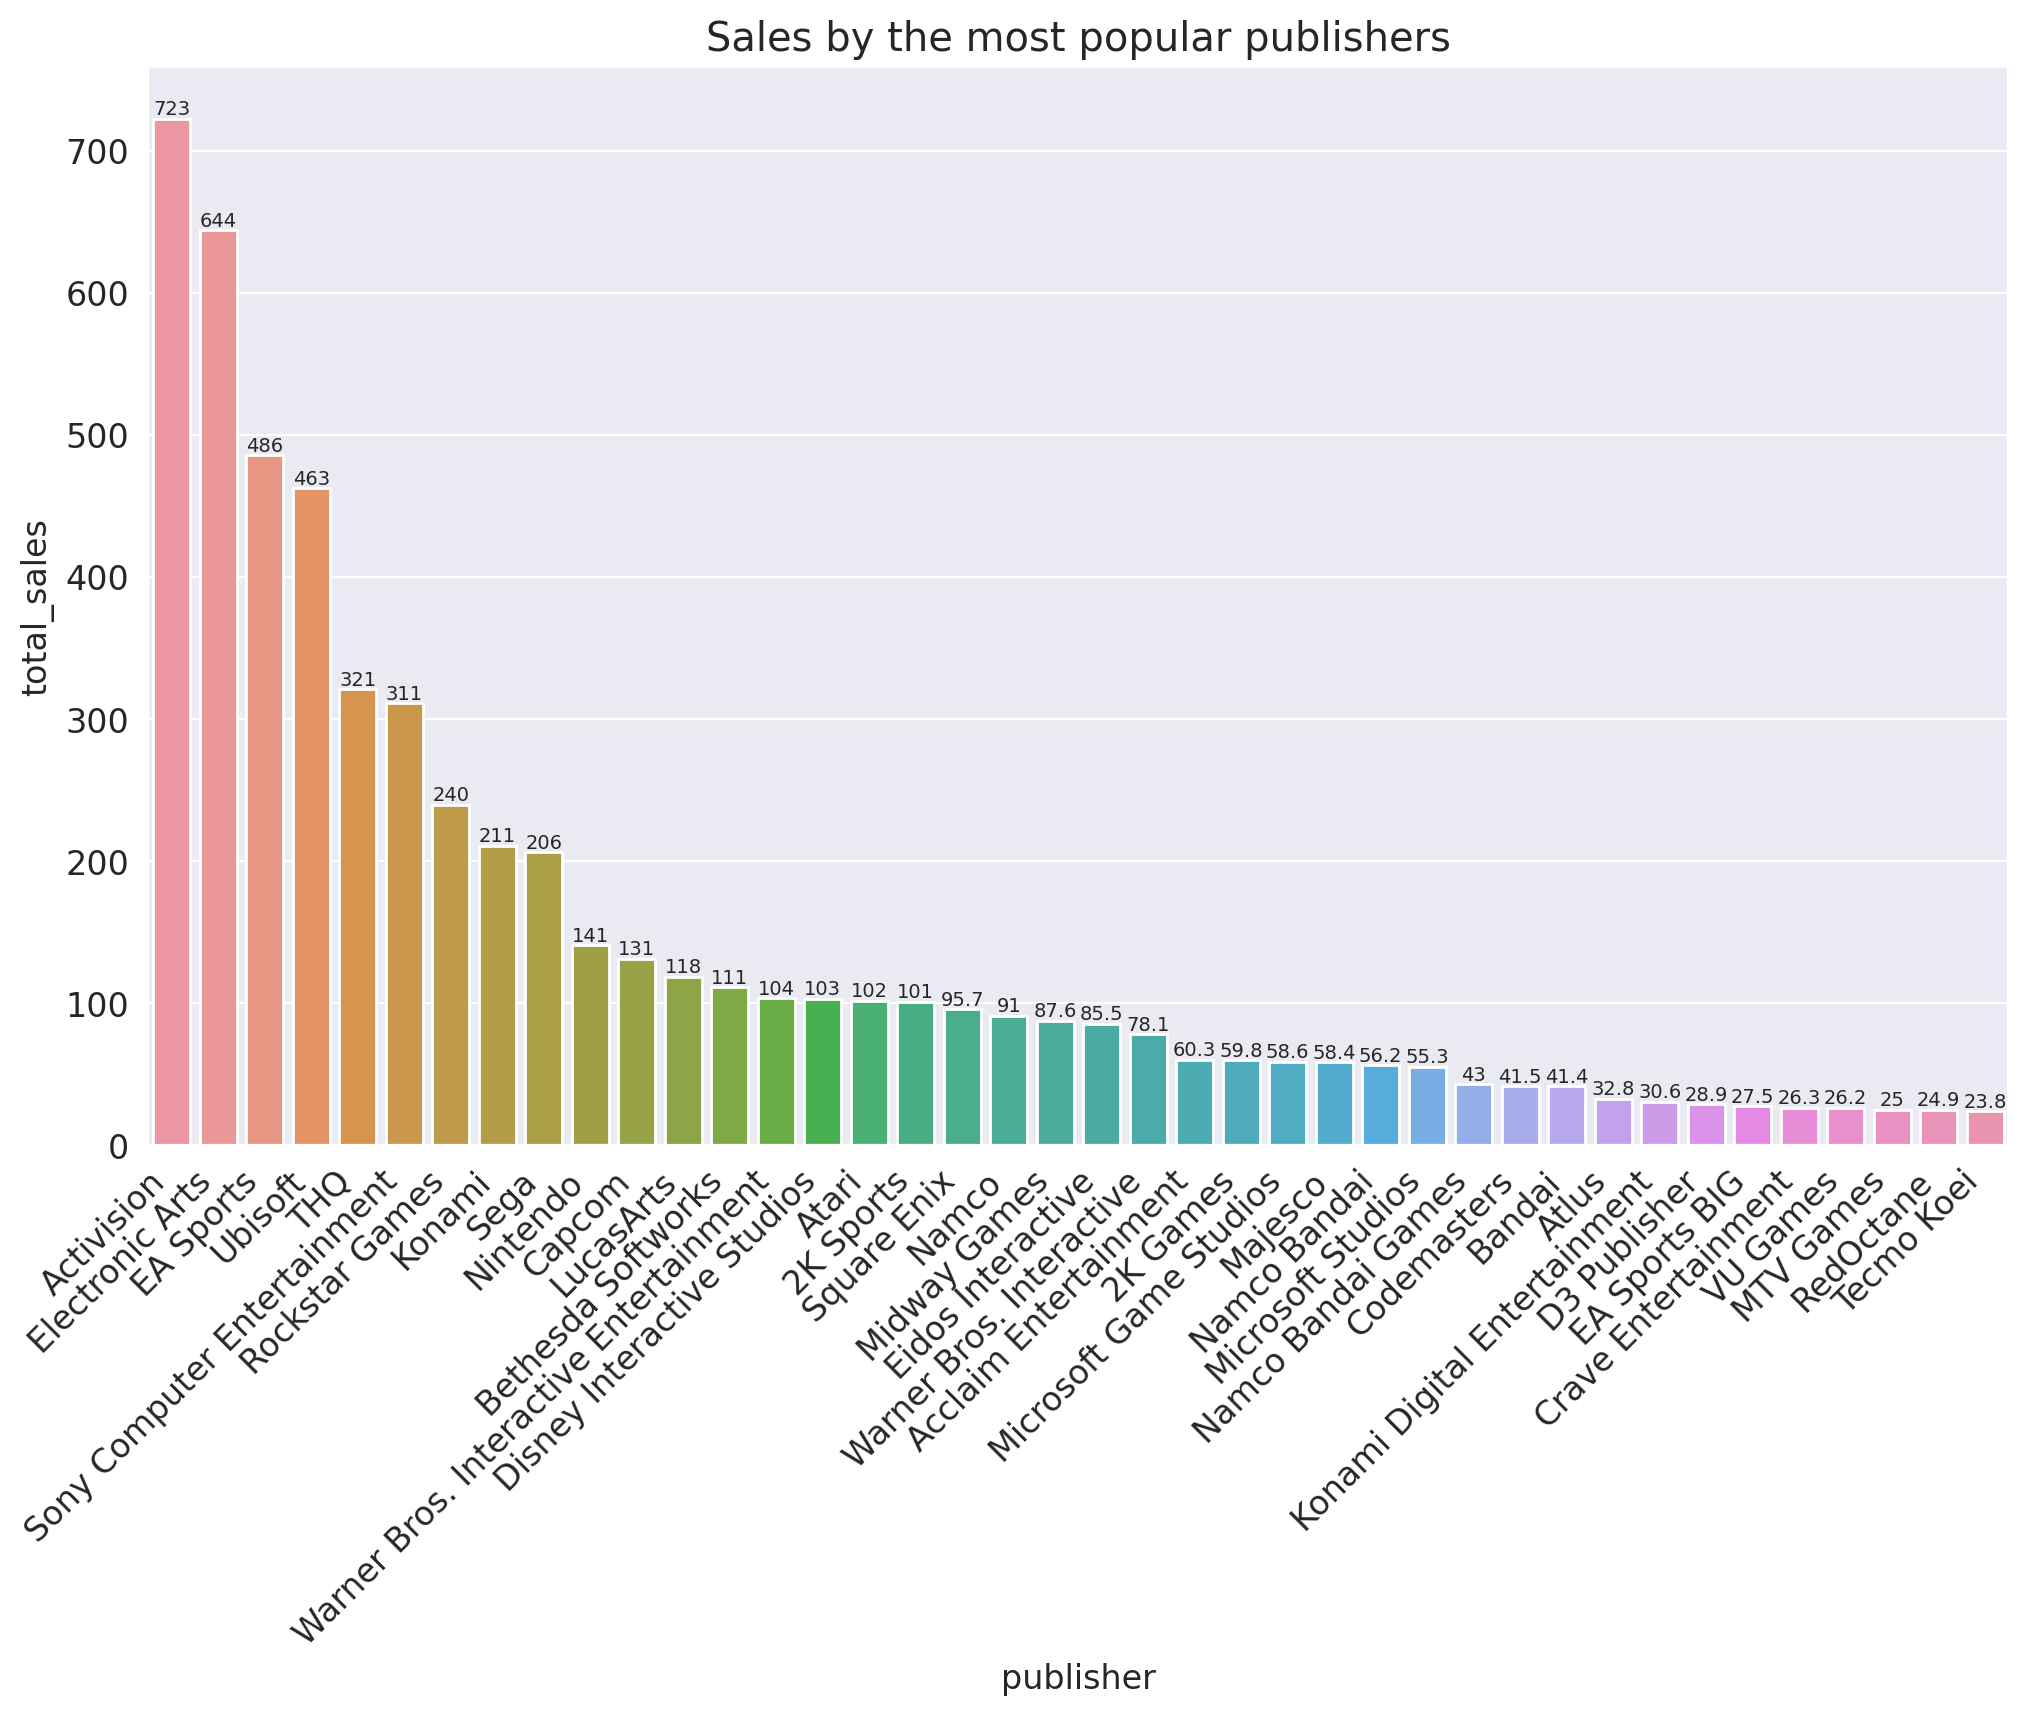

In [25]:
# Построим график продаж по издателям

sales_by_publisher = game_data.groupby('publisher')['total_sales'].sum().reset_index(name='total_sales').sort_values('total_sales', ascending=False)
ax = sns.barplot(data=sales_by_publisher[:40], x='publisher', y='total_sales')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title('Sales by the most popular publishers')
ax.bar_label(ax.containers[0], fontsize=7, fmt='%.3g');
plt.show()

EA is the most successful publisher, just as expected.

In [26]:
game_data.groupby(by=game_data['release_date'].dt.date)['release_date'].count()

release_date
1977-01-01     2
1977-10-01     1
1978-01-01     7
1979-01-01     1
1980-01-01     2
              ..
2020-02-14     1
2020-04-07     1
2020-08-21     2
2020-10-27     1
2020-12-31    23
Name: release_date, Length: 4120, dtype: int64

In [27]:
day_month_releases = game_data.groupby(game_data['release_date'].astype(str).str[5:])['release_date']\
                              .count().rename('Number of releases').rename_axis('release_date')\
                              .reset_index(name='count')

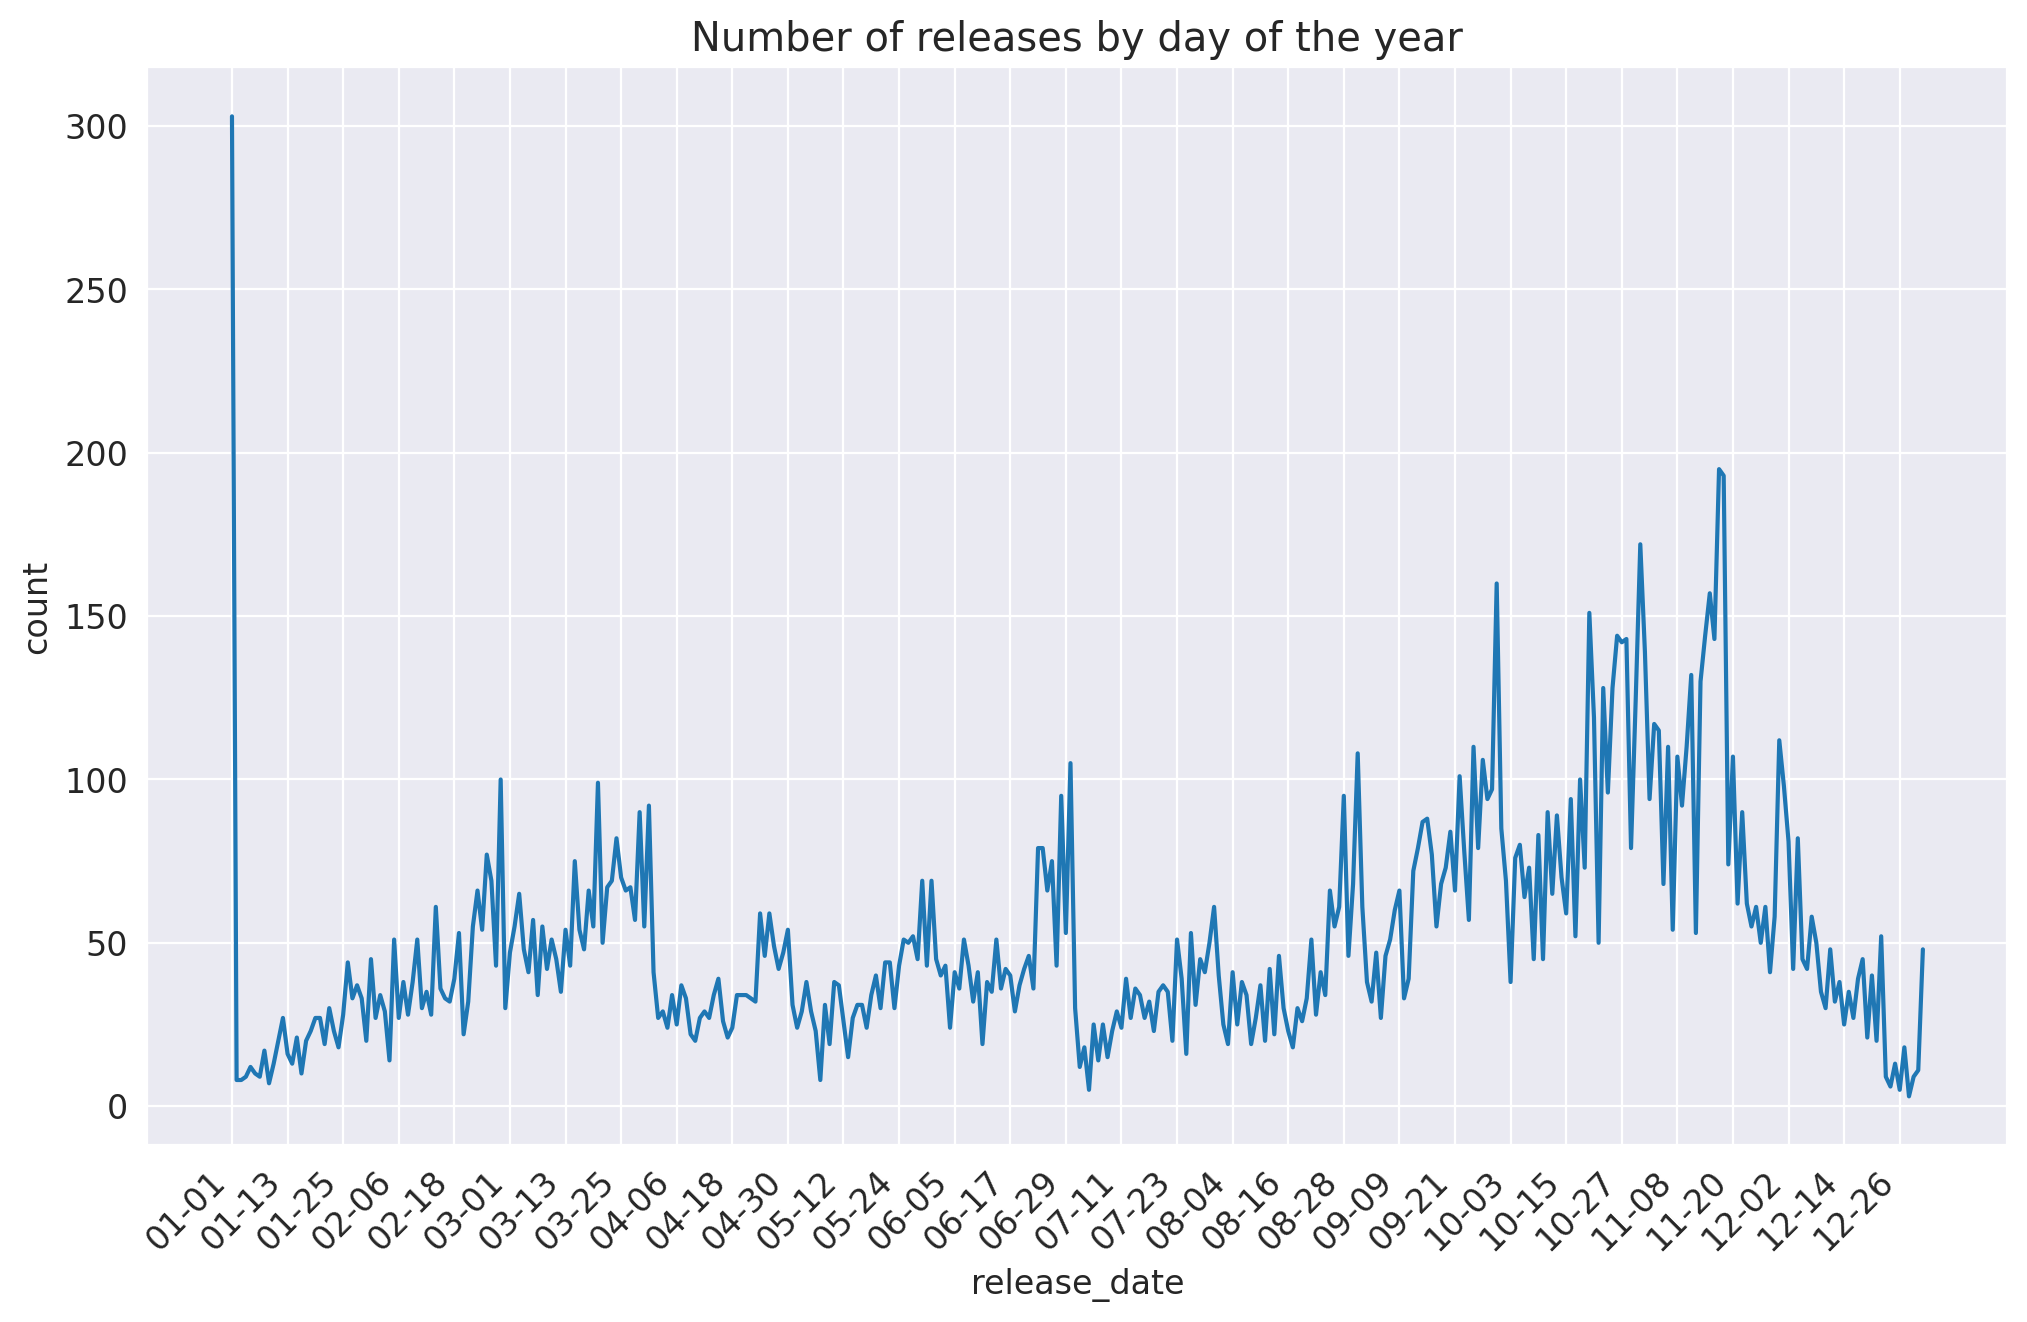

In [28]:
ax = sns.lineplot(data=day_month_releases, x='release_date', y='count')
ax.set(xticks=day_month_releases['release_date'][::12].tolist())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title('Number of releases by day of the year')
plt.show()

In [29]:
game_data[game_data['release_date'].astype(str).str[5:] == '01-01']

,img,title,console,genre,publisher,developer,has_critic_score,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
125,/games/boxart/8536311ccc.jpg,Asteroids,2600,Shooter,Atari,Atari,False,0.0,4.31,4.00,0.00,0.26,0.05,1981-01-01,1981-01-01
391,/games/boxart/2618476ccc.jpg,Monopoly,PC,Misc,Hasbro Interactive,Unknown,False,0.0,2.39,1.49,0.00,0.81,0.10,1995-01-01,1995-01-01
392,/games/boxart/2862420ccc.jpg,Mortal Kombat II (US & Others sales),GEN,Fighting,Acclaim Entertainment,Probe Entertainment Limited,False,0.0,2.39,1.78,0.00,0.53,0.08,1994-01-01,1994-01-01
445,/games/boxart/2883362ccc.jpg,R.B.I. Baseball,NES,Sports,Tengen,Namco,False,0.0,2.20,0.15,2.05,0.00,0.00,1988-01-01,1988-01-01
464,/games/boxart/1195402ccc.jpg,SimCity 2000,PC,Simulation,Maxis,Maxis,True,8.0,2.14,1.20,0.00,0.84,0.10,1993-01-01,1993-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18507,/games/boxart/full_real-crimes-jack-the-ripper...,Real Crimes: Jack the Ripper,PC,Puzzle,Virtual Playground,Virtual Playground,False,0.0,0.00,0.00,0.00,0.00,0.00,2010-01-01,2010-01-01
18580,/games/boxart/5709635ccc.jpg,SimFarm,PC,Simulation,Maxis,Maxis Software,False,0.0,0.00,0.00,0.00,0.00,0.00,1993-01-01,1993-01-01
18584,/games/boxart/full_simtower_637AmericaFront.jpg,SimTower,PC,Simulation,Maxis,Open Book,False,0.0,0.00,0.00,0.00,0.00,0.00,1994-01-01,1994-01-01
18881,/games/boxart/full_6761982PALFrontccc.jpg,Rayman Gold,PC,Platform,Ubisoft,Ubisoft,False,0.0,0.00,0.00,0.00,0.00,0.00,1997-01-01,1997-01-01


Strangely, a lot of games was released at the 1st of the January. I've made a little research and came to the conclusion that the part of theese games are old and we don't know precise release date, so it's set to the first day of the year, some of the games got New Year's update and never updated after, and some of them were actually released at the January 1st.

Late autumn and pre-Christmas time are the most popular for releases. We can separate graph to the following parts: 01-01 to 04-01, 04-01 to 07-01, 07-01 to 12-31. The first two parts shows the same pattern: slow increase in releases and a steep fall at the end. The third part is more like normal distribution, and also the period 12-24 to 12-31 experiences the least number of releases (for obvious reasons).

In [30]:
sales_to_date = game_data.groupby(game_data['release_date'])['total_sales']\
                              .sum().rename('Number of sales').rename_axis('release_date')\
                              .reset_index(name='total_sales')

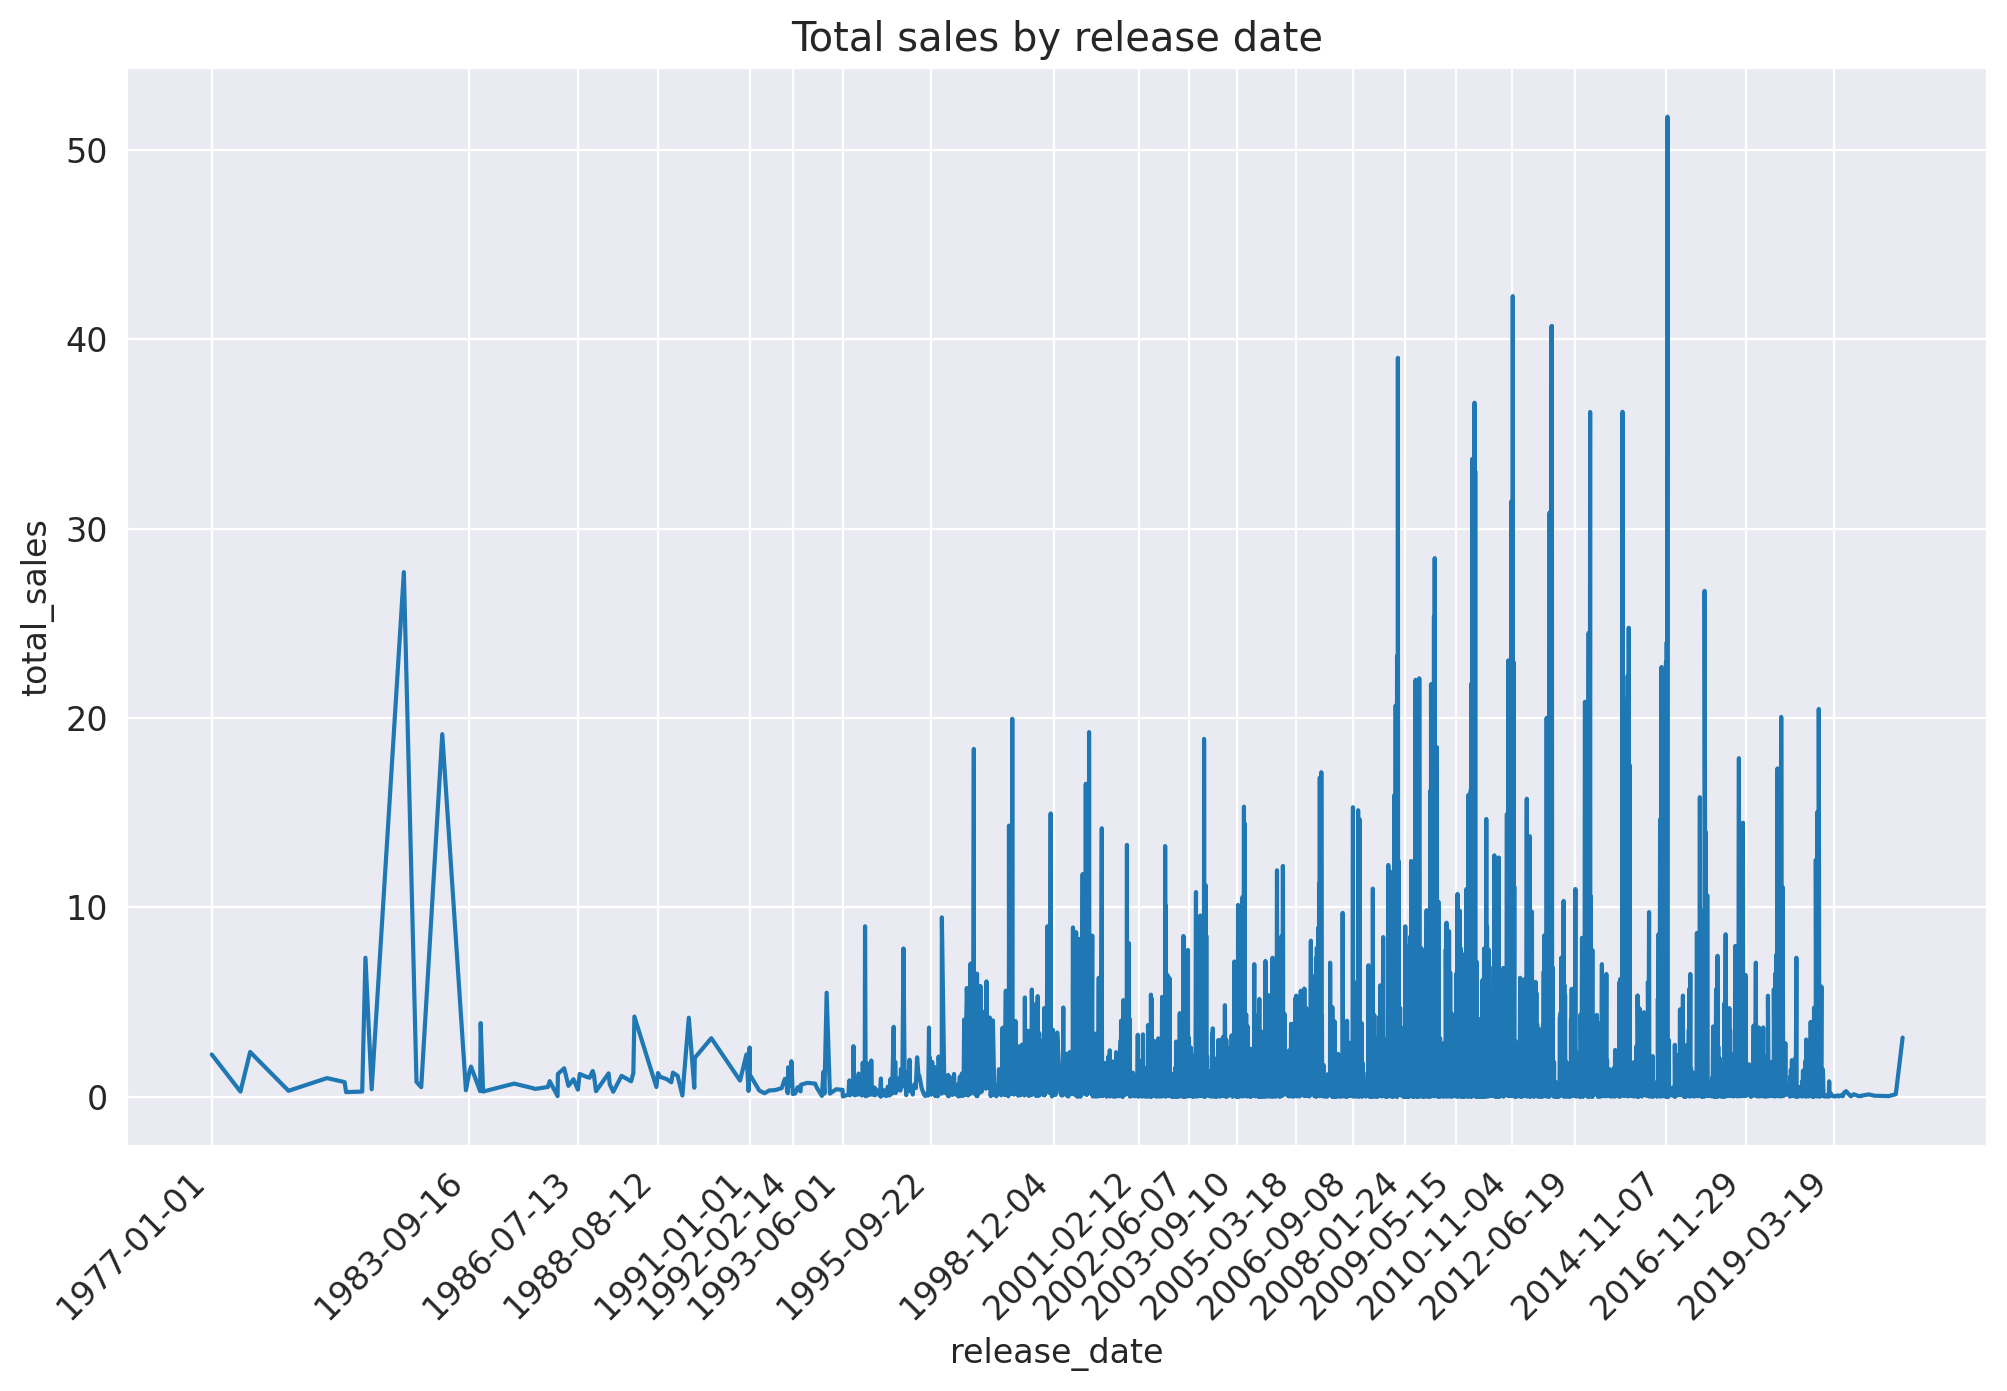

In [31]:
ax = sns.lineplot(data=sales_to_date, x='release_date', y='total_sales')
ax.set(xticks=sales_to_date['release_date'][:100:15].tolist() + sales_to_date['release_date'][200::300].tolist())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title('Total sales by release date')
plt.show()

We se that since 2019 there were no populars games in the dataset, so we can say that this is an anomaly, or maybe theese games was deleted, because they did not have total_sales value. It can be noticed that big spires has almost equal gaps between each other. We also see that density of the releases is much less in the 20th century, but we have 2 big peaks in the past. Let's have a look.

In [32]:
game_data[game_data['release_date'] < datetime(1985, 1, 1)][game_data['total_sales'] > 1.5]

,img,title,console,genre,publisher,developer,has_critic_score,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
125,/games/boxart/8536311ccc.jpg,Asteroids,2600,Shooter,Atari,Atari,False,0.0,4.31,4.00,0.0,0.26,0.05,1981-01-01,1981-01-01
467,/games/boxart/6174127ccc.jpg,Demon Attack,2600,Shooter,Imagic,Imagic,False,0.0,2.13,1.99,0.0,0.12,0.02,1982-01-01,1982-01-01
532,/games/boxart/6239190ccc.jpg,E.T.: The Extra Terrestrial,2600,Action,Atari,Atari,False,0.0,1.97,1.84,0.0,0.11,0.02,1982-01-01,1982-01-01
711,/games/boxart/7869614ccc.jpg,Ms. Pac-Man,2600,Puzzle,Atari,General Entertainment,False,0.0,1.65,1.54,0.0,0.10,0.02,1982-01-01,1982-01-01
719,/games/boxart/7222772ccc.jpg,Dig Dug,2600,Puzzle,Atari,Atari,False,0.0,1.64,1.52,0.0,0.10,0.02,1983-01-01,1983-01-01
740,/games/boxart/5200578ccc.jpg,River Raid,2600,Shooter,Activision,Activision,False,0.0,1.60,1.49,0.0,0.09,0.02,1982-01-01,1982-01-01
742,/games/boxart/full_8608062AmericaFrontccc.jpg,Mario Bros.,2600,Platform,Atari,Atari,False,0.0,1.59,1.48,0.0,0.09,0.02,1983-10-01,1983-10-01


In [33]:
games_1981 = list(game_data.loc[game_data['release_date'] == datetime(1981, 1, 1), 'title'])
games_1982 = list(game_data.loc[game_data['release_date'] == datetime(1982, 1, 1), 'title'])
games_1983 = list(game_data.loc[game_data['release_date'] == datetime(1983, 1, 1), 'title'])
print('Games of 1981:', '\t'.join(games_1981), sep='\n', end='\n\n')
print('Games of 1982:', '\t'.join(games_1982), sep='\n', end='\n\n')
print('Games of 1983:', '\t'.join(games_1983), sep='\n', end='\n\n')

Games of 1981:
Asteroids	Kaboom!	Defender	Ice Hockey	Freeway

Games of 1982:
Demon Attack	E.T.: The Extra Terrestrial	Ms. Pac-Man	River Raid	Donkey Kong	Centipede	Atlantis	Megamania	Cosmic Ark	Spider-Man	Custer's Revenge	Alien	Air Raid	Berzerk	King Kong	Adventures of Tron	Smurf: Rescue In Gargamel's Castle	BurgerTime	Raiders of the Lost Ark	Grand Prix	Jawbreaker	Phoenix	Barnstorming	Mouse Trap	Airlock	Dragonfire	Frogs And Flies	Fantastic Voyage	Carnival	Fireball	Astroblast	Fast Food	RealSports Football	Front Line	Dark Cavern	Crazy Climber	Deadly Duck	Reactor	RealSports Baseball	International Soccer	Armor Ambush	RealSports Volleyball

Games of 1983:
Dig Dug	Pole Position	Moon Patrol	Jungle Hunt	Joust	Donkey Kong Junior	Enduro	Galaxian	Kangaroo	Keystone Kapers	X-Man	Halloween	Battlezone	Q*bert	The Activision Decathlon	Action Force	Popeye	Gauntlet	RealSports Tennis	Congo Bongo	Bump 'n' Jump	Gravitar	Bank Heist	Alien's Return	Frankenstein's Monster	Mountain King	Polaris	Mr. Do!	Porky's	Ass

We see, that a lot of very popular games were released during these 3 years, like Donkey Kong or Mario Bros, and because we don't know exact release date for the most of these games, we have the same situatuion with the 1st of the January as we saw before. Overall this period describes the first boom of gaming industry, and potential reason for such an explosion could be the release of the famous Asteroids game, which has the most amount of total_sales among other games on the list.

Let's now look at connection between games and genres.

In [34]:
pd.DataFrame(game_data.groupby('genre')['total_sales'].count())

,total_sales
genre,
Action,2825
Action-Adventure,264
Adventure,1889
Board Game,3
Education,4
Fighting,867
MMO,30
Misc,1990
Music,147


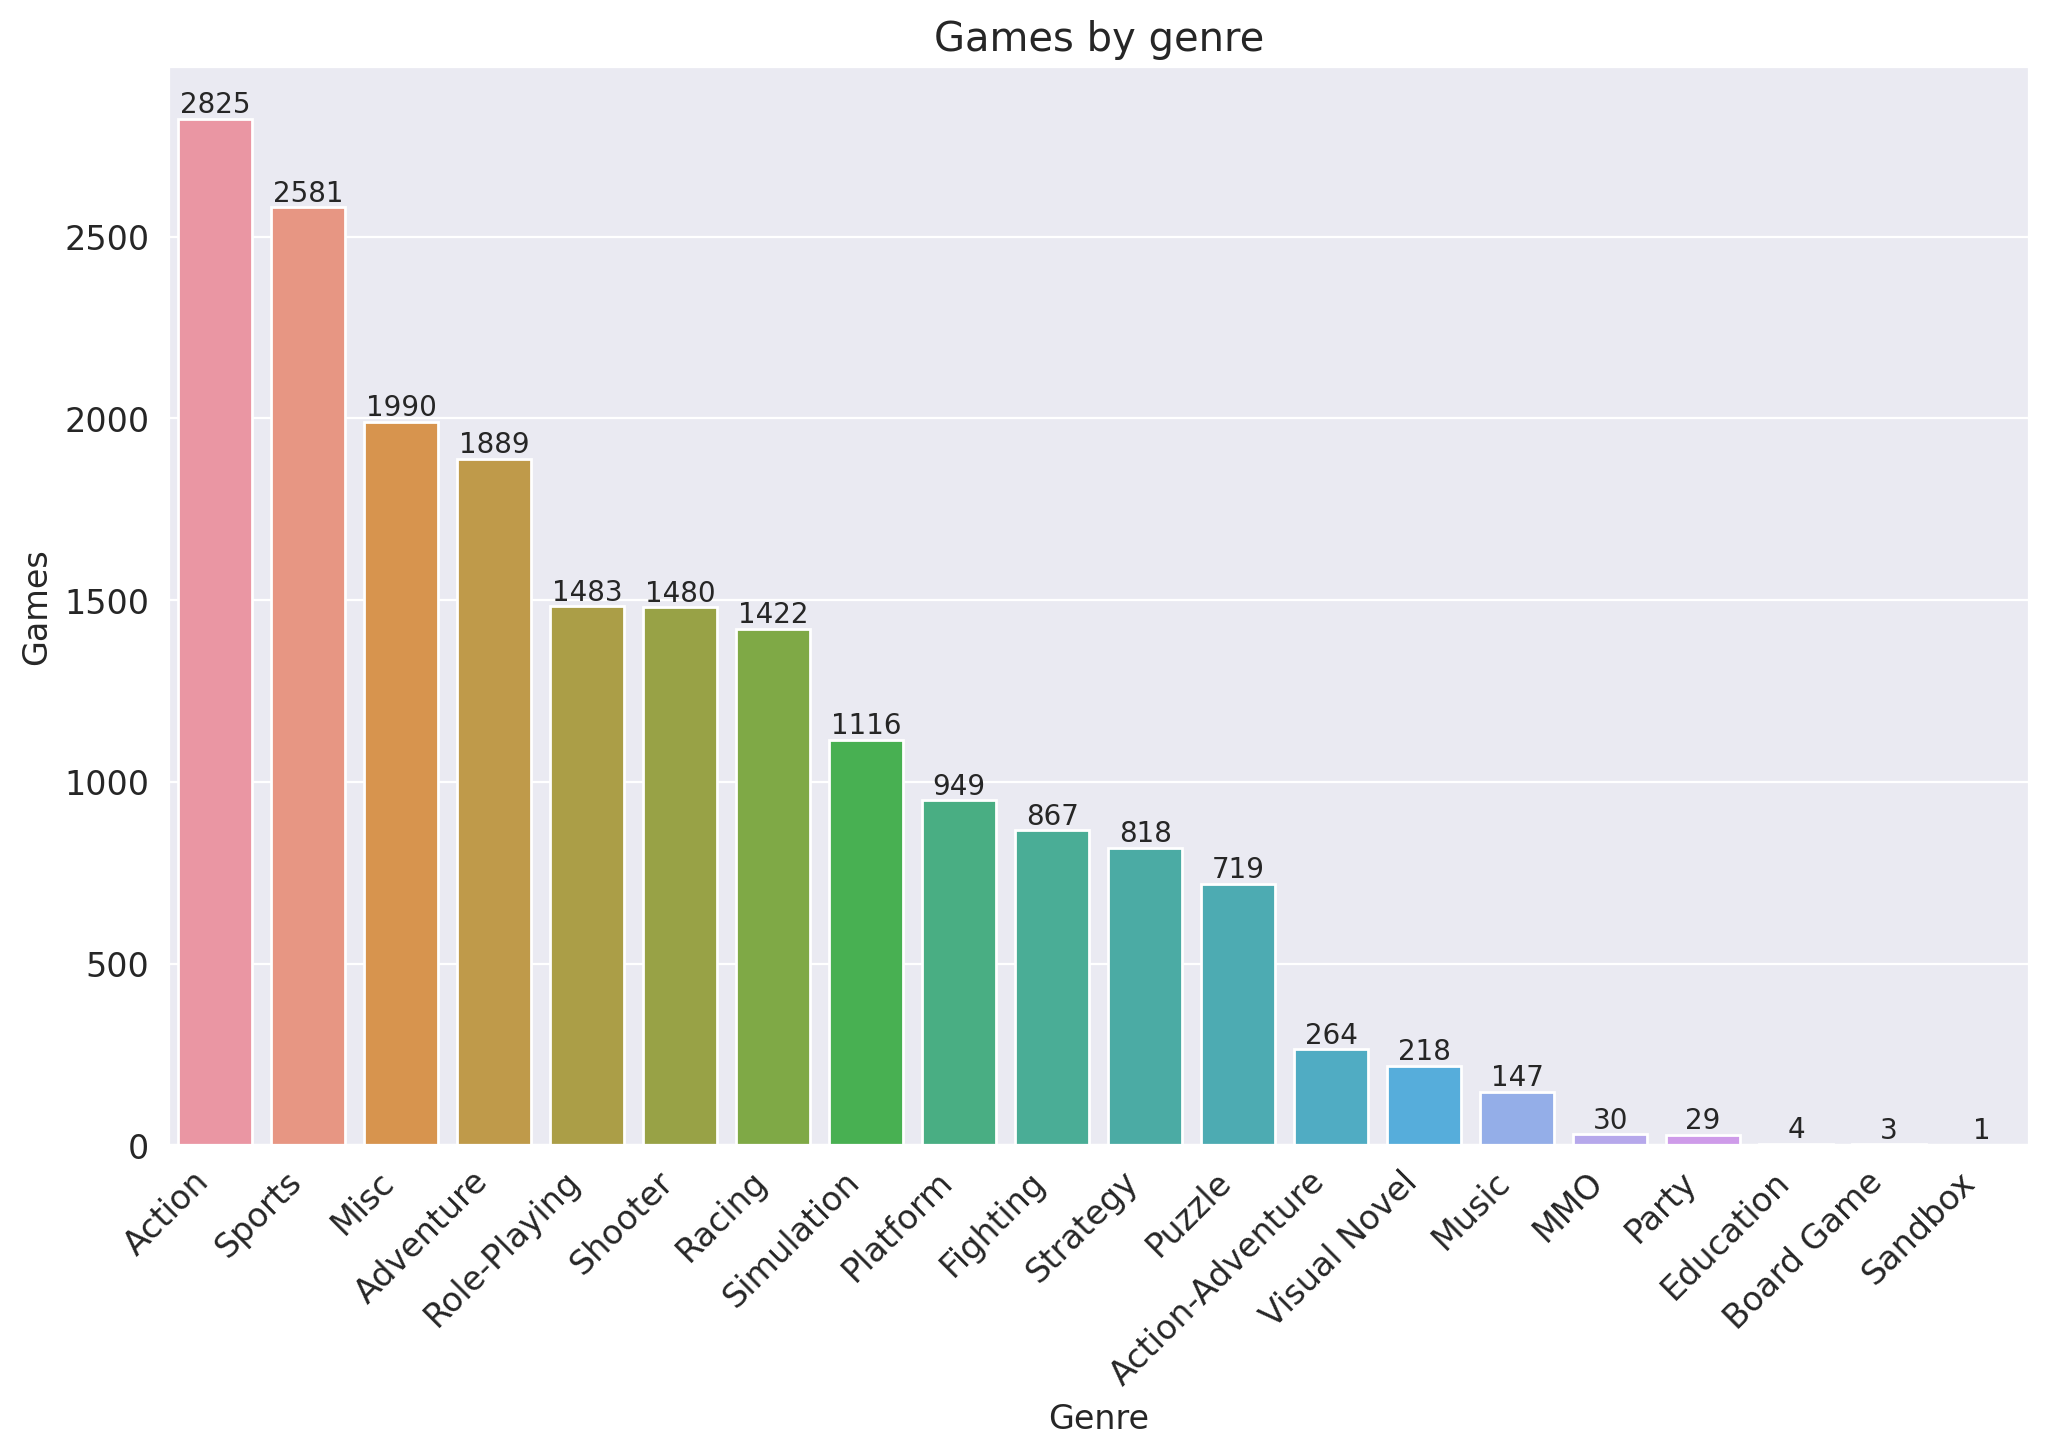

In [35]:
games_to_genre = pd.DataFrame(game_data.groupby('genre')['total_sales'].count()).sort_values('total_sales', ascending=False)
ax = sns.barplot(data=games_to_genre, x=games_to_genre.index, y='total_sales')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title('Games by genre')
ax.set_ylabel('Games')
ax.set_xlabel('Genre')
ax.bar_label(ax.containers[0], fontsize=10, fmt='%.5g');
plt.show()

In [36]:
game_data.groupby('genre')['total_sales'].mean()

genre
Action              0.398212
Action-Adventure    0.562576
Adventure           0.172223
Board Game          0.110000
Education           0.242500
Fighting            0.392607
MMO                 0.310333
Misc                0.280201
Music               0.352041
Party               0.214138
Platform            0.367914
Puzzle              0.176718
Racing              0.368150
Role-Playing        0.287175
Sandbox             1.890000
Shooter             0.672615
Simulation          0.269247
Sports              0.459810
Strategy            0.144572
Visual Novel        0.026514
Name: total_sales, dtype: float64

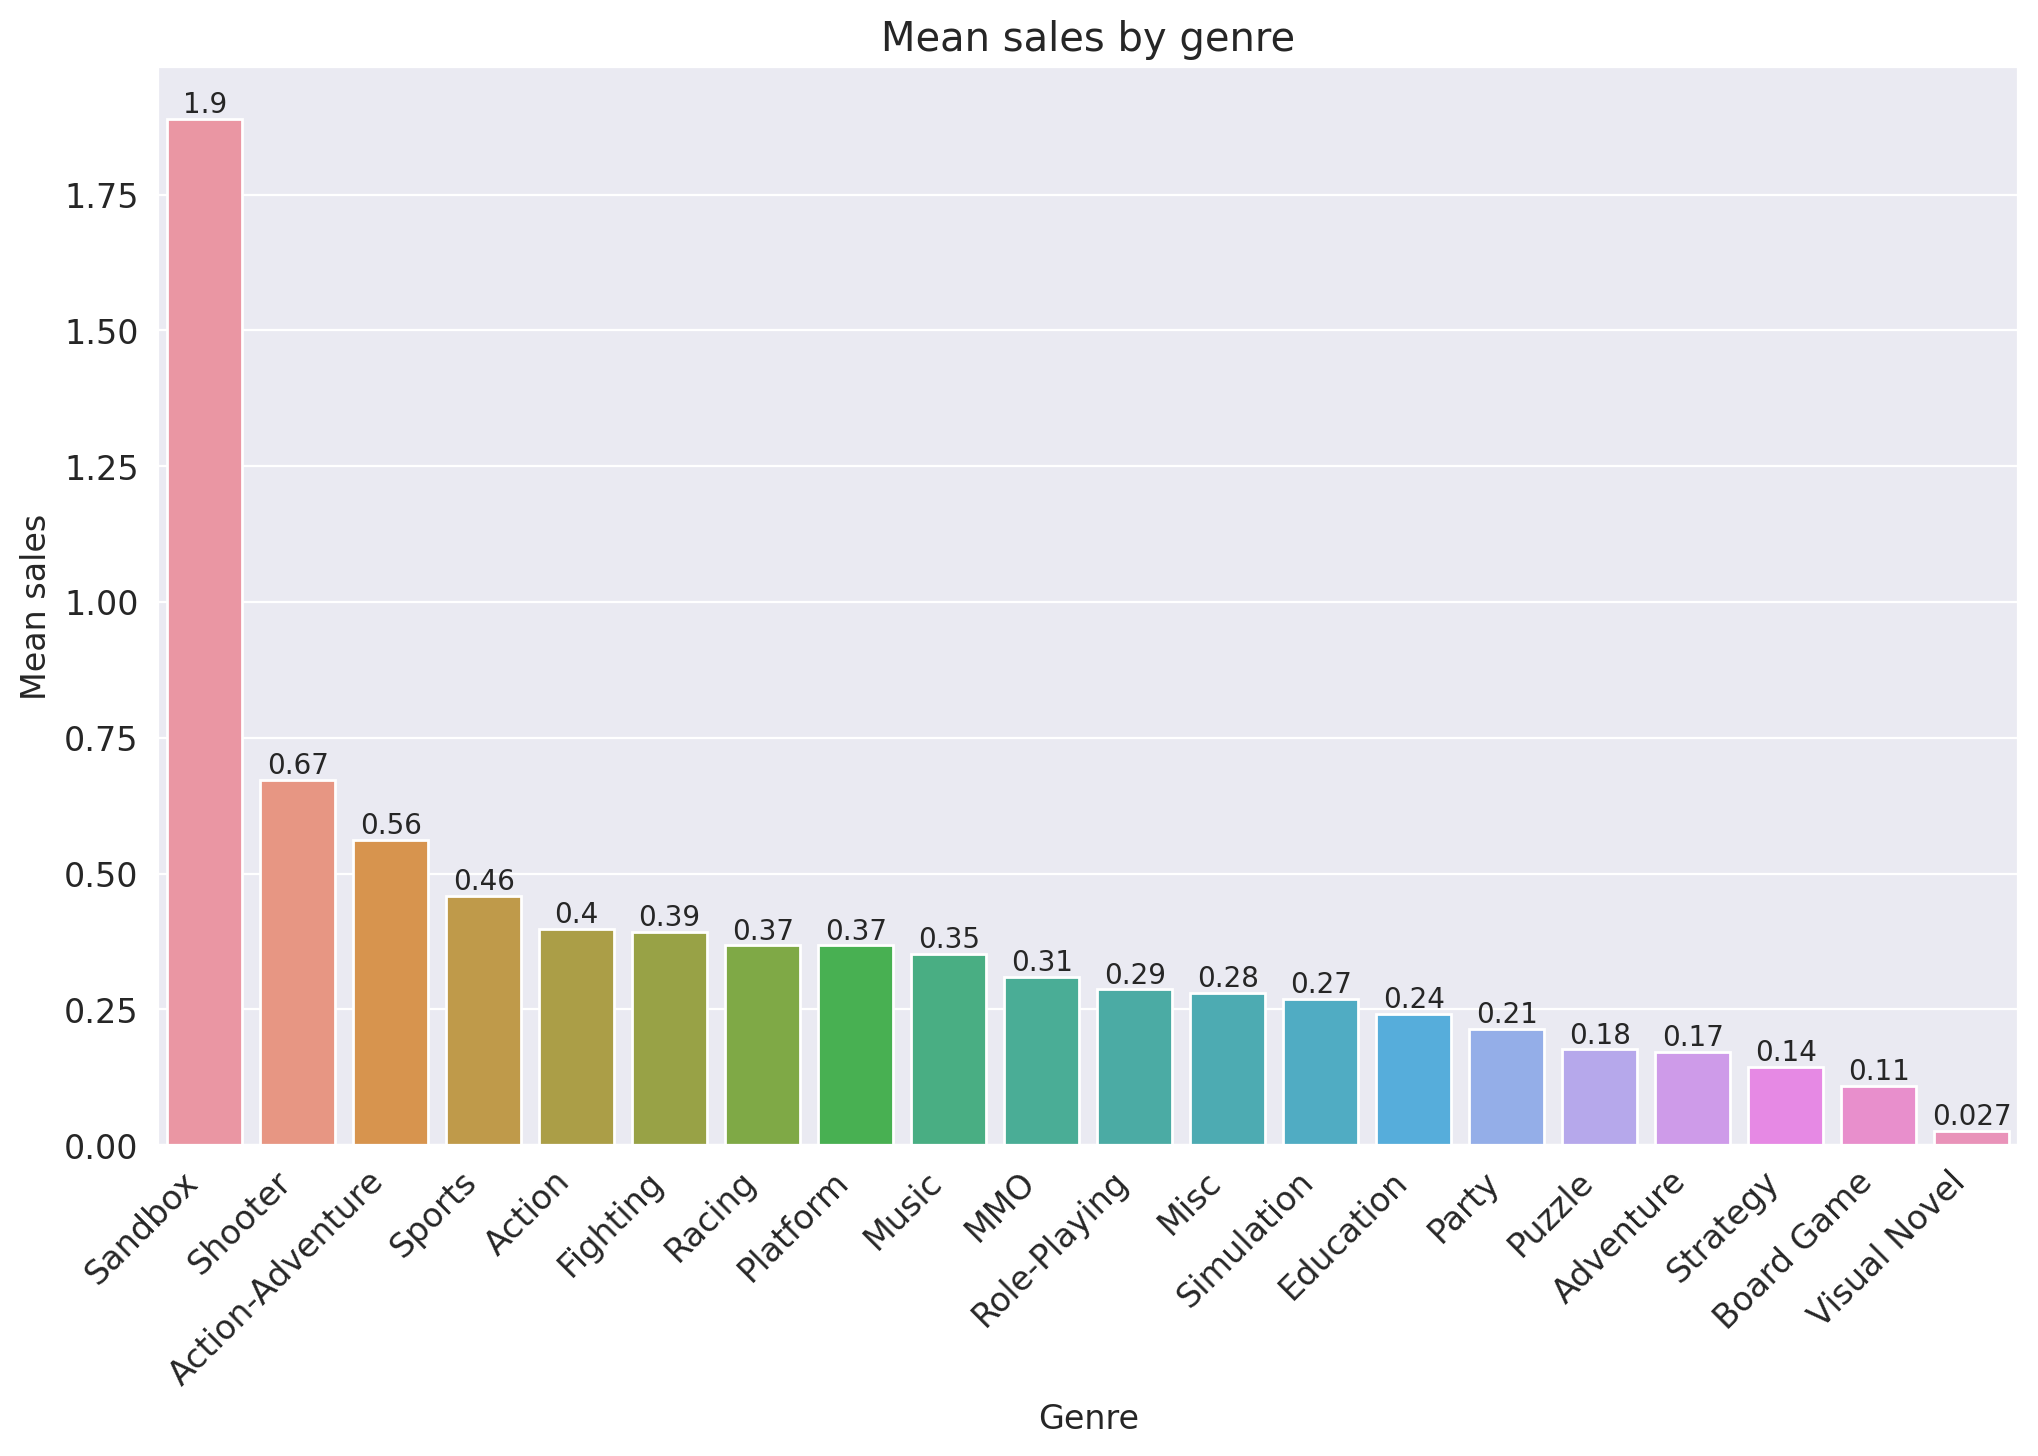

In [37]:
sales_to_genre = pd.DataFrame(game_data.groupby('genre')['total_sales'].mean()).sort_values('total_sales', ascending=False)
ax = sns.barplot(data=sales_to_genre, x=sales_to_genre.index, y='total_sales')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title('Mean sales by genre')
ax.set_ylabel('Mean sales')
ax.set_xlabel('Genre')
ax.bar_label(ax.containers[0], fontsize=10, fmt='%.2g');
plt.show()

In [38]:
game_data[game_data['genre'] == 'Sandbox']

,img,title,console,genre,publisher,developer,has_critic_score,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
571,/games/boxart/full_8777882AmericaFrontccc.jpg,Minecraft,NS,Sandbox,Mojang,4J Studios,True,9.2,1.89,0.69,0.52,0.56,0.12,2018-06-21,2019-01-26


We see that there is only one Sandbox game in the dataset and it's one of the most popular games in the world called Minecraft. That explains why the sandbox genre is so high above other genres at the picture above.

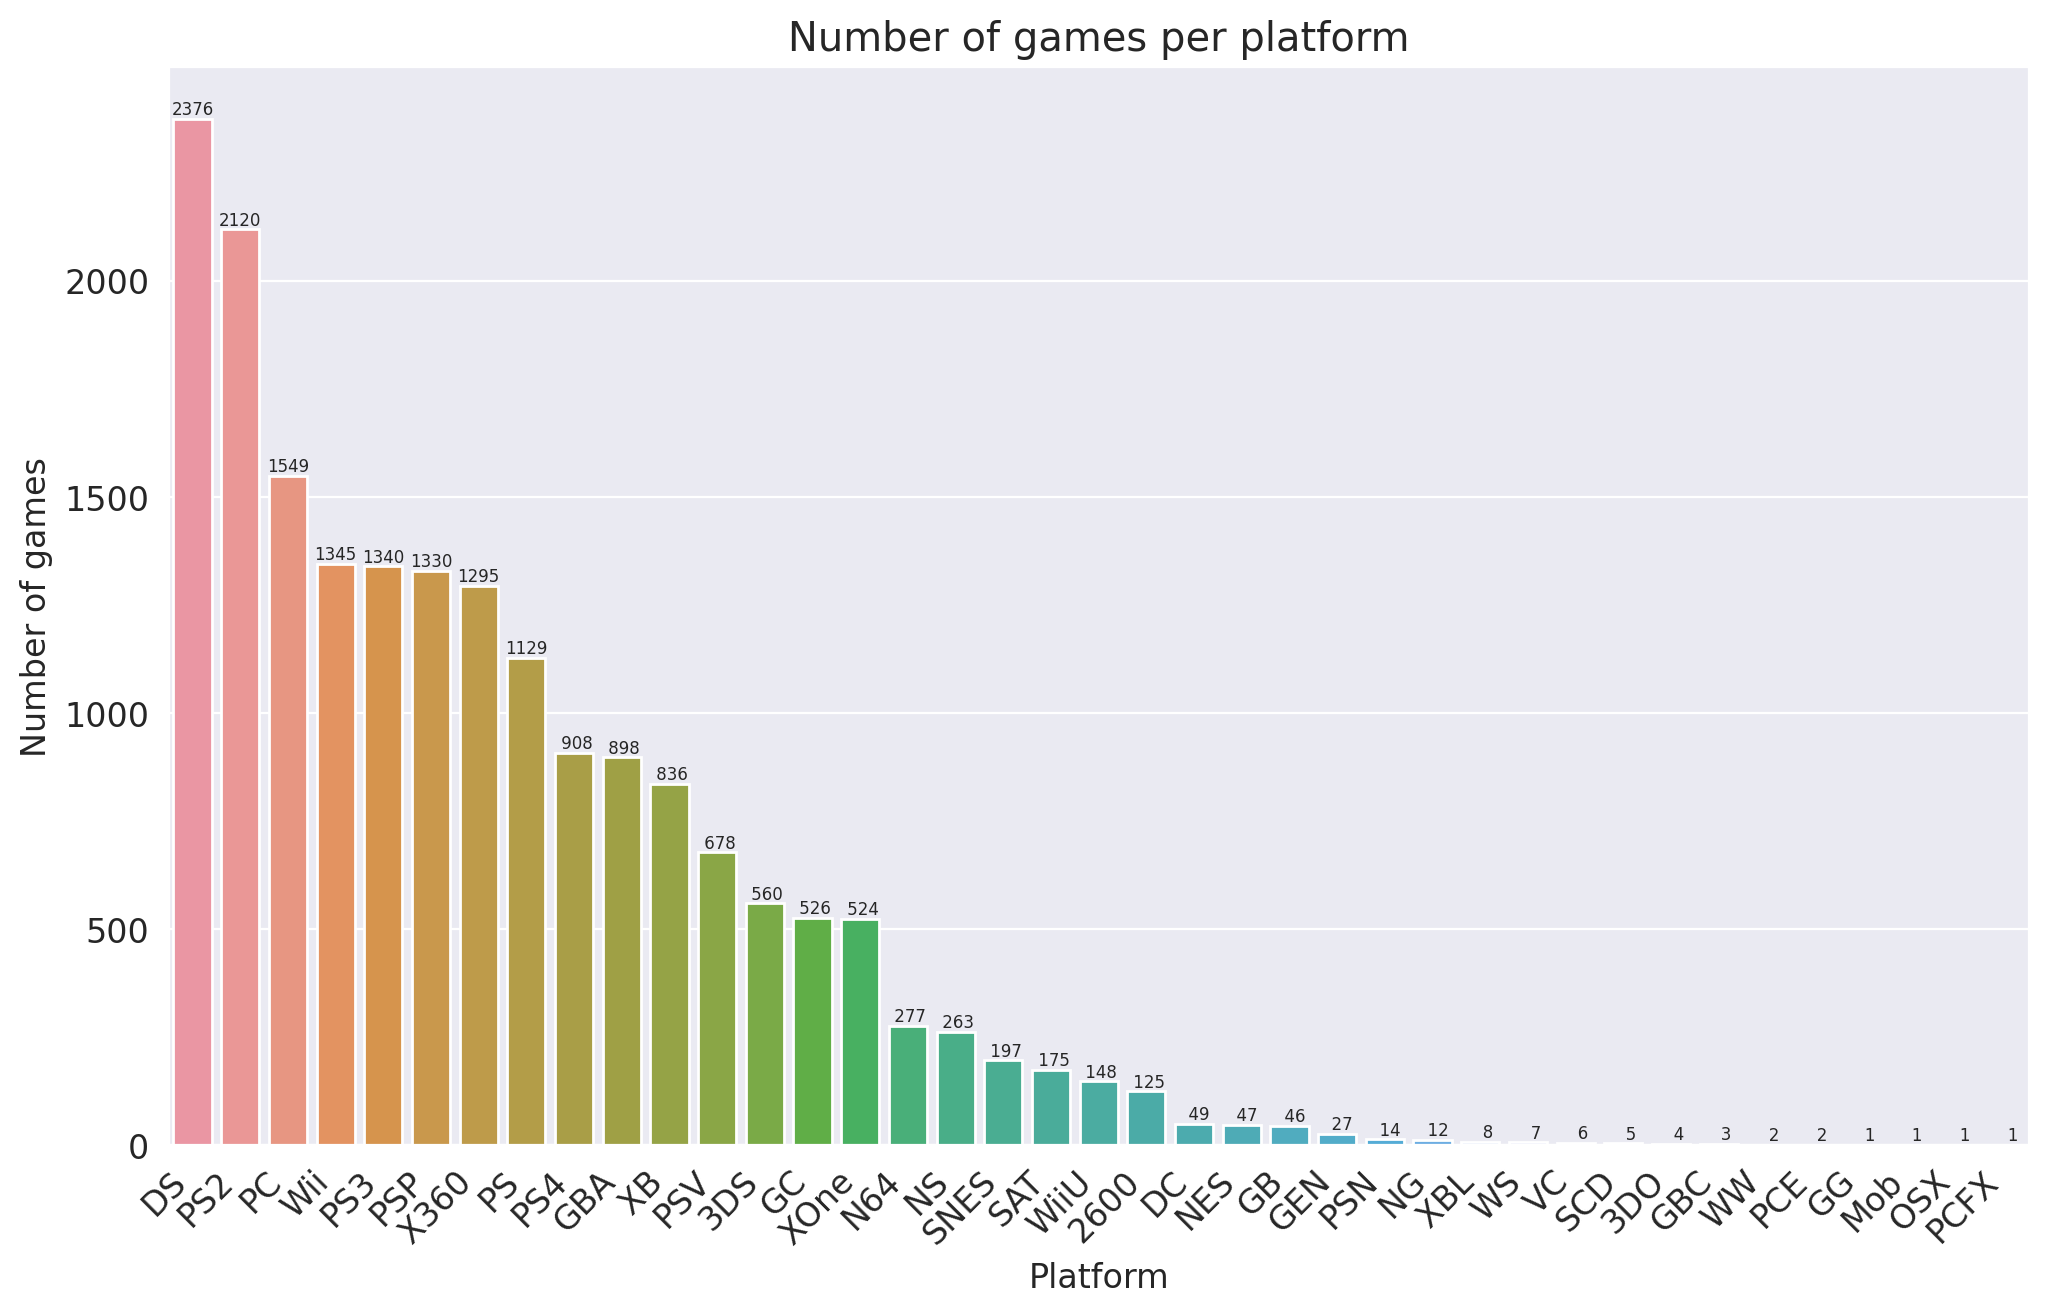

In [39]:
sales_to_genre = pd.DataFrame(game_data.groupby('console')['total_sales'].count()).sort_values('total_sales', ascending=False)
ax = sns.barplot(data=sales_to_genre, x=sales_to_genre.index, y='total_sales')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title('Number of games per platform')
ax.set_ylabel('Number of games')
ax.set_xlabel('Platform')
ax.bar_label(ax.containers[0], fontsize=6, fmt='%4g');
plt.show()